In [2]:
# 1. Project Setup and Environment Configuration
from google.colab import drive
drive.mount('/content/drive/')

import os
pip_cache_dir = '/content/drive/MyDrive/pip_cache'
os.makedirs(pip_cache_dir, exist_ok=True)
os.environ['PIP_CACHE_DIR'] = pip_cache_dir

project_dir = '/content/drive/MyDrive/project'
os.chdir(project_dir)
print(f"Current working directory: {os.getcwd()}")

!pip install -r requirements.txt > /dev/null

Mounted at /content/drive/
Current working directory: /content/drive/MyDrive/project


# AI4EO Water Body Segmentation Project

## 1. Problem Description

### Background
Water body monitoring is crucial for environmental management and disaster prevention. Traditional manual interpretation of satellite imagery is time-consuming and subjective. This project develops an automated deep learning solution for water body segmentation in remote sensing images.

### Problem Statement
**Objective**: Develop an AI system to automatically identify and segment water bodies (rivers, lakes, ponds) from high-resolution satellite/aerial imagery.

**Challenges**:
- Varying water appearance due to lighting conditions
- Complex backgrounds (urban areas, vegetation)
- Different water body sizes and shapes
- Seasonal and weather variations

### Applications
- **Water Resource Management**: Monitor water body changes over time
- **Flood Assessment**: Rapid flood extent mapping during disasters
- **Environmental Monitoring**: Track water quality and ecosystem health
- **Urban Planning**: Support infrastructure development decisions

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import albumentations as A
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from sklearn.metrics import jaccard_score, f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix

# Device configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


Found 2841 images and 2841 masks


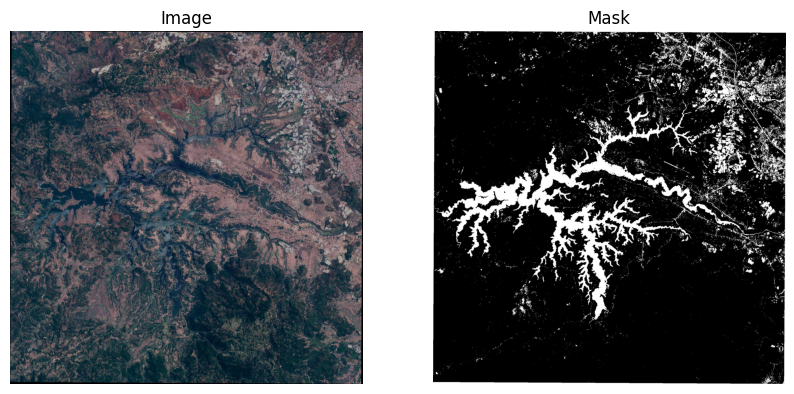

Training set: 1989 samples
Validation set: 425 samples
Test set: 427 samples


In [71]:
# Data Loading and Preprocessing
# Optimized hyperparameters
height, width = (256, 256)
EPOCHS = 30
BATCH_SIZE = 16
LR = 0.0003
ENCODER = 'resnet34'
WEIGHTS = 'imagenet'

project_dir = os.getcwd()
data_dir = os.path.join(project_dir, 'data')
models_dir = os.path.join(project_dir, 'models')

# Get data files
images_list = sorted(glob.glob(os.path.join(data_dir, 'images', '*')))
masks_list = sorted(glob.glob(os.path.join(data_dir, 'masks', '*')))

print(f"Found {len(images_list)} images and {len(masks_list)} masks")

# Check if image and mask counts match
if len(images_list) != len(masks_list):
    print("Warning: Number of images and masks don't match! Please check your data.")

# Visualize one image-mask pair
if len(images_list) > 0:
    img_path = images_list[0]
    mask_path = masks_list[0]

    img = Image.open(img_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Mask")
    plt.axis('off')
    plt.show()
else:
    print("No images and masks found")

# Dataset split: 70% train, 15% validation, 15% test
X_temp, X_test, y_temp, y_test = train_test_split(
    images_list, masks_list, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42
)

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Training dataset: 1989 samples
Validation dataset: 425 samples
Test dataset: 427 samples


<ipython-input-72-b941190f6dc9>:41: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


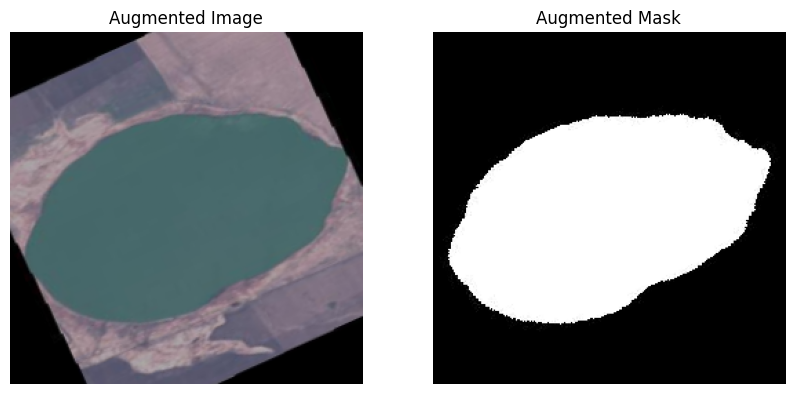

In [72]:
# Dataset Class and Data Augmentation
class Load_Data(Dataset):
    def __init__(self, image_list, mask_list, transform=None):
        super().__init__()
        self.images_list = image_list
        self.mask_list = mask_list
        self.transform = transform

    def __getitem__(self, idx):
        img = Image.open(self.images_list[idx]).convert('RGB')
        mask = Image.open(self.mask_list[idx]).convert('L')

        img = np.array(img)
        mask = np.array(mask)

        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img.astype(np.float32) / 255.0
        img = torch.tensor(img, dtype=torch.float32)

        mask = np.expand_dims(mask, axis=0)
        mask = mask.astype(np.float32) / 255.0
        mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask

    def __len__(self):
        return len(self.images_list)

# Optimized data augmentation strategy
train_transform = A.Compose([
    A.Resize(height, width),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
])

valid_transform = A.Compose([A.Resize(height, width)])

# Create datasets
train_dataset = Load_Data(X_train, y_train, transform=train_transform)
valid_dataset = Load_Data(X_val, y_val, transform=valid_transform)
test_dataset = Load_Data(X_test, y_test, transform=valid_transform)

print(f"Training dataset: {len(train_dataset)} samples")
print(f"Validation dataset: {len(valid_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

# Visualize one training sample (with augmentation)
if len(train_dataset) > 0:
    img, mask = train_dataset[0]  # Get first training sample

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # Convert (C, H, W) back to (H, W, C)
    plt.title("Augmented Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(mask.numpy()), cmap='gray')  # Remove single channel dimension
    plt.title("Augmented Mask")
    plt.axis('off')
    plt.show()
else:
    print("Training dataset is empty, cannot visualize sample.")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

## 2. Technical Approach

### Remote Sensing Data
- **Data Source**: High-resolution satellite/aerial imagery
- **Spectral Bands**: RGB channels (Red, Green, Blue)
- **Spatial Resolution**: Variable, processed to 256×256 pixels
- **Ground Truth**: Manually annotated binary masks (water=1, background=0)

### AI Algorithm: U-Net with ResNet Encoder

#### Architecture Overview
Input Image (3×H×W)
↓
ResNet50 Encoder (Feature Extraction)

↓

U-Net Decoder (Upsampling + Skip Connections)

↓

Output Logits (1×H×W)

↓

Sigmoid Activation → Probability Map

↓

Threshold (>0.5) → Binary Mask

#### Key Components:
1. **Encoder (ResNet34)**:
   - Pre-trained on ImageNet
   - Extracts hierarchical features
   - Downsampling path: 256→128→64→32→16

2. **Decoder (U-Net)**:
   - Upsampling path: 16→32→64→128→256
   - Skip connections preserve spatial details
   - Combines low-level and high-level features

3. **Loss Function**:
   - Combined Dice Loss + Binary Cross Entropy
   - Dice Loss: Handles class imbalance
   - BCE Loss: Pixel-wise classification

#### Training Strategy:
- **Data Augmentation**: Rotation, flipping, brightness adjustment
- **Optimization**: Adam optimizer with learning rate scheduling
- **Validation**: Hold-out validation set for model selection
- **Early Stopping**: Prevent overfitting

### Evaluation Metrics
- **IoU (Intersection over Union)**: Overlap between prediction and ground truth
- **Dice Coefficient**: Harmonic mean of precision and recall
- **Pixel Accuracy**: Correctly classified pixels / total pixels
- **Precision**: True positives / (True positives + False positives)
- **Recall**: True positives / (True positives + False negatives)

In [73]:
# Model Definition
class SegmentationModel(nn.Module):
    def __init__(self, encoder_name='resnet34', encoder_weights='imagenet', in_channels=3, classes=1): #resnet50
        super(SegmentationModel, self).__init__()
        self.arc = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights=encoder_weights,
            in_channels=in_channels,
            classes=classes,
            activation=None
        )

    def forward(self, images, masks=None):
        logits = self.arc(images)
        if masks is not None:
            dice_loss = DiceLoss(mode='binary')(logits, masks)
            bce_loss = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, dice_loss, bce_loss
        return logits

# Create model
model = SegmentationModel(encoder_name=ENCODER, encoder_weights=WEIGHTS)
model.to(DEVICE)

# Optimizer and learning rate scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 24,436,369


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [74]:
#Training
def train_fn(data_loader, model, optimizer):
    model.train()
    total_loss = 0.0
    loop = tqdm(data_loader, desc="Training", leave=False)

    for images, masks in loop:
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.to(DEVICE, dtype=torch.float32)

        optimizer.zero_grad()
        logits, dice_loss, bce_loss = model(images, masks)
        loss = dice_loss + bce_loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(data_loader)

def eval_fn(data_loader, model):
    model.eval()
    total_loss = 0.0
    loop = tqdm(data_loader, desc="Validation", leave=False)

    with torch.no_grad():
        for images, masks in loop:
            images = images.to(DEVICE, dtype=torch.float32)
            masks = masks.to(DEVICE, dtype=torch.float32)

            logits, dice_loss, bce_loss = model(images, masks)
            loss = dice_loss + bce_loss

            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

    return total_loss / len(data_loader)

In [75]:
# training loop
best_val_loss = np.inf
model_save_dir = os.path.join(models_dir, ENCODER)
os.makedirs(model_save_dir, exist_ok=True)

best_model_path = os.path.join(model_save_dir, "best_model.pt")

train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    # Training
    train_loss = train_fn(train_loader, model, optimizer)
    train_losses.append(train_loss)

    # Validation
    val_loss = eval_fn(valid_loader, model)
    val_losses.append(val_loss)

    print(f'Train Loss: {train_loss:.5f} | Val Loss: {val_loss:.5f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'train_losses': train_losses,
            'val_losses': val_losses
        }, best_model_path)
        print(f'Best model saved at epoch {epoch+1} with val_loss: {val_loss:.5f}')

    # Early stopping
    if epoch > 10 and val_loss > min(val_losses[-10:]) * 1.1:
        print("Early stopping triggered")
        break

print(f"Training completed. Best model saved at: {best_model_path}")

Starting training...

Epoch 1/30


Train Loss: 0.79614 | Val Loss: 0.56191
Best model saved at epoch 1 with val_loss: 0.56191

Epoch 2/30


Train Loss: 0.63293 | Val Loss: 0.53349
Best model saved at epoch 2 with val_loss: 0.53349

Epoch 3/30


Train Loss: 0.58605 | Val Loss: 0.51795
Best model saved at epoch 3 with val_loss: 0.51795

Epoch 4/30


Train Loss: 0.56370 | Val Loss: 0.48176
Best model saved at epoch 4 with val_loss: 0.48176

Epoch 5/30


Train Loss: 0.54560 | Val Loss: 0.47053
Best model saved at epoch 5 with val_loss: 0.47053

Epoch 6/30


Train Loss: 0.53186 | Val Loss: 0.47639

Epoch 7/30


Train Loss: 0.52947 | Val Loss: 0.44923
Best model saved at epoch 7 with val_loss: 0.44923

Epoch 8/30


Train Loss: 0.50209 | Val Loss: 0.41782
Best model saved at epoch 8 with val_loss: 0.41782

Epoch 9/30


Train Loss: 0.48456 | Val Loss: 0.43461

Epoch 10/30


Train Loss: 0.47328 | Val Loss: 0.45319

Epoch 11/30


Train Loss: 0.48812 | Val Loss: 0.44074

Epoch 12/30


Train Loss: 0.47035 | Val Loss: 0.41047
Best model saved at epoch 12 with val_loss: 0.41047

Epoch 13/30


Train Loss: 0.46968 | Val Loss: 0.43587

Epoch 14/30


Train Loss: 0.49531 | Val Loss: 0.39837
Best model saved at epoch 14 with val_loss: 0.39837

Epoch 15/30


Train Loss: 0.47031 | Val Loss: 0.42359

Epoch 16/30


Train Loss: 0.46107 | Val Loss: 0.40568

Epoch 17/30


Train Loss: 0.46118 | Val Loss: 0.40354

Epoch 18/30


Train Loss: 0.44127 | Val Loss: 0.38427
Best model saved at epoch 18 with val_loss: 0.38427

Epoch 19/30


Train Loss: 0.43619 | Val Loss: 0.38914

Epoch 20/30


Train Loss: 0.44576 | Val Loss: 0.37611
Best model saved at epoch 20 with val_loss: 0.37611

Epoch 21/30


Train Loss: 0.43687 | Val Loss: 0.41718
Early stopping triggered
Training completed. Best model saved at: /content/drive/MyDrive/project/models/resnet34/best_model.pt


In [76]:
# Test Set Evaluation
def calculate_metrics(pred_masks, true_masks, threshold=0.5):
    """Calculate segmentation metrics"""
    pred_binary = (pred_masks > threshold).astype(int)
    true_binary = true_masks.astype(int)

    # Flatten all pixels
    pred_flat = pred_binary.flatten()
    true_flat = true_binary.flatten()

    # Calculate metrics
    iou = jaccard_score(true_flat, pred_flat, zero_division=0)
    dice = f1_score(true_flat, pred_flat, zero_division=0)
    accuracy = accuracy_score(true_flat, pred_flat)
    precision = precision_score(true_flat, pred_flat, zero_division=0)
    recall = recall_score(true_flat, pred_flat, zero_division=0)

    return {
        'IoU': iou,
        'Dice': dice,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall
    }

print("=" * 50)
print("Test Set Evaluation Results (Using Best Model)")
print("=" * 50)

model.eval()
all_pred_masks = []
all_true_masks = []

print("Running inference on test set...")
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing with best model"):
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.to(DEVICE, dtype=torch.float32)

        logits = model(images)
        pred_probs = torch.sigmoid(logits)

        all_pred_masks.append(pred_probs.cpu().numpy())
        all_true_masks.append(masks.cpu().numpy())

# Concatenate all predictions
all_pred_masks = np.concatenate(all_pred_masks, axis=0)
all_true_masks = np.concatenate(all_true_masks, axis=0)

# Calculate metrics
metrics = calculate_metrics(all_pred_masks, all_true_masks)

print("Test Set Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

# Confusion matrix
pred_binary = (all_pred_masks > 0.5).astype(int).flatten()
true_binary = all_true_masks.astype(int).flatten()
cm = confusion_matrix(true_binary, pred_binary)

print(f"\nConfusion Matrix:")
print(f"[[TN={cm[0,0]}, FP={cm[0,1]}],")
print(f" [FN={cm[1,0]}, TP={cm[1,1]}]]")

total_pixels = len(true_binary)
water_pixels = np.sum(true_binary)
background_pixels = total_pixels - water_pixels

print(f"\nDataset Statistics:")
print(f"Total pixels: {total_pixels:,}")
print(f"Water pixels: {water_pixels:,} ({water_pixels/total_pixels*100:.1f}%)")
print(f"Background pixels: {background_pixels:,} ({background_pixels/total_pixels*100:.1f}%)")

Test Set Evaluation Results (Using Best Model)
Running inference on test set...


Testing with best model: 100%|██████████| 27/27 [00:04<00:00,  6.11it/s]


Test Set Performance Metrics:
IoU: 0.7030
Dice: 0.8256
Accuracy: 0.8944
Precision: 0.7576
Recall: 0.9069

Confusion Matrix:
[[TN=18036551, FP=2236915],
 [FN=717494, TP=6992912]]

Dataset Statistics:
Total pixels: 27,983,872
Water pixels: 7,710,406 (27.6%)
Background pixels: 20,273,466 (72.4%)


Test Set Prediction Visualization:


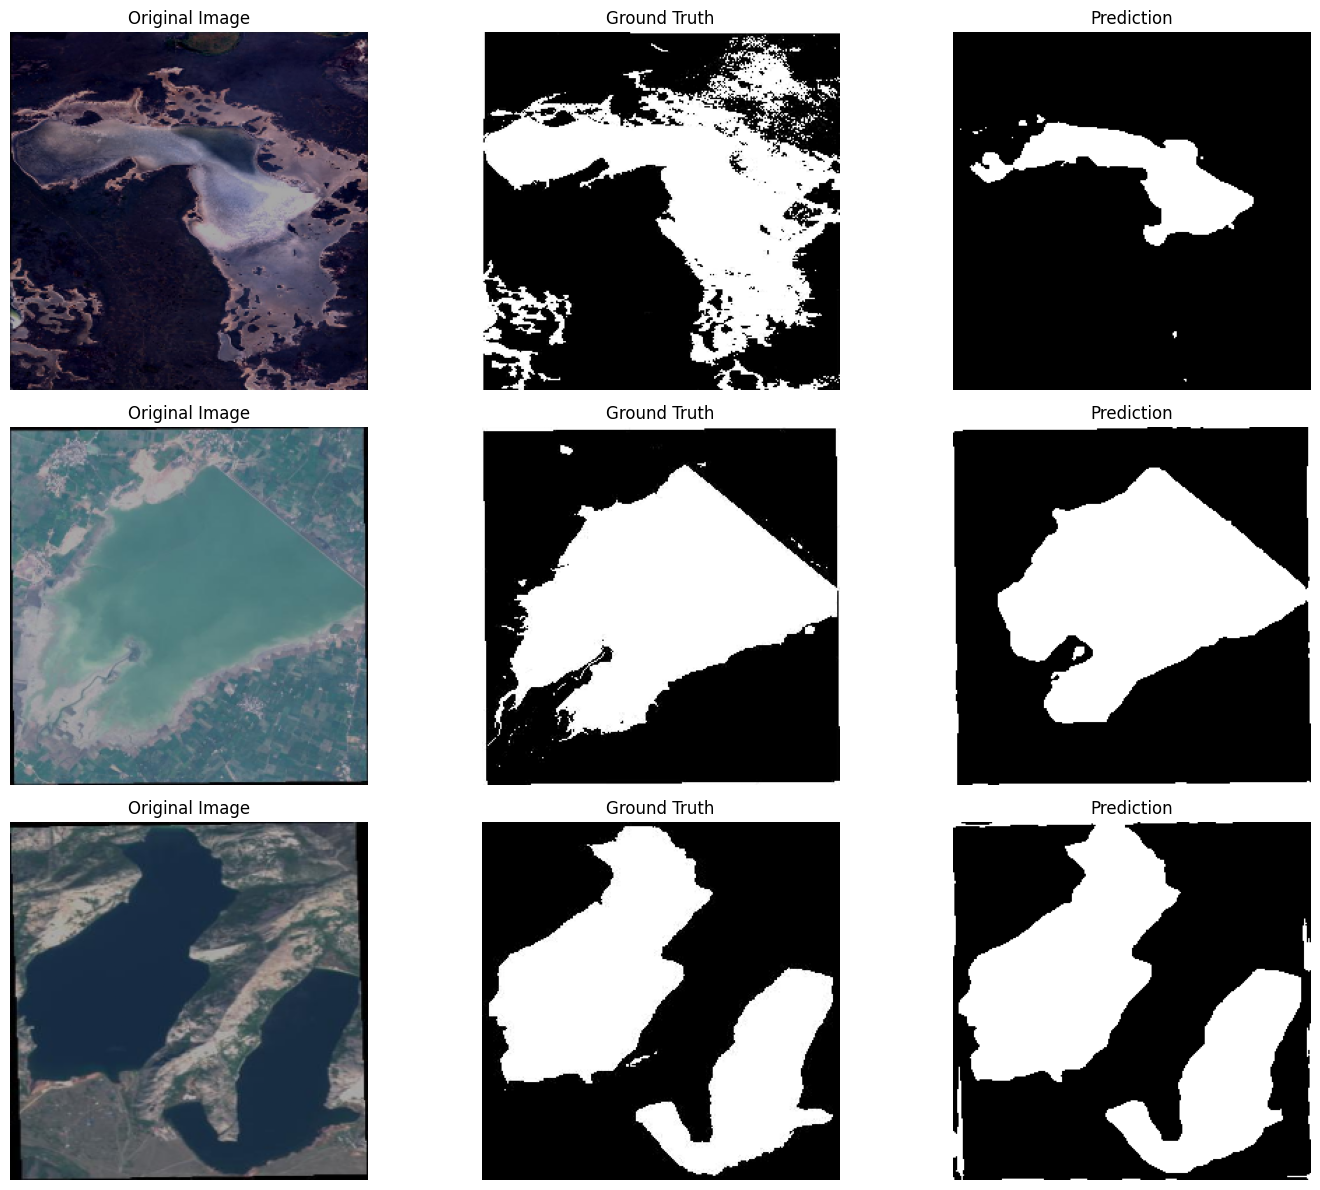

In [77]:
# Results Visualization
checkpoint = torch.load(best_model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

def visualize_results(dataset, model, num_samples=3):
    """Visualize prediction results"""
    model.eval()
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*4))

    with torch.no_grad():
        for i in range(num_samples):
            image, mask = dataset[i]
            image_input = image.unsqueeze(0).to(DEVICE)

            logits = model(image_input)
            pred_prob = torch.sigmoid(logits)
            pred_mask = (pred_prob > 0.5).float()

            # Convert to numpy for display
            image_np = np.transpose(image.numpy(), (1, 2, 0))
            mask_np = np.squeeze(mask.numpy())
            pred_np = np.squeeze(pred_mask.cpu().numpy())

            axes[i, 0].imshow(image_np)
            axes[i, 0].set_title('Original Image')
            axes[i, 0].axis('off')

            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')

            axes[i, 2].imshow(pred_np, cmap='gray')
            axes[i, 2].set_title('Prediction')
            axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

print("Test Set Prediction Visualization:")
visualize_results(test_dataset, model, num_samples=3)

In [80]:
#  Environmental Impact Assessment
print("=" * 50)
print("Environmental Impact Assessment")
print("=" * 50)

# Estimate computational resource consumption
total_params = sum(p.numel() for p in model.parameters())
model_size_mb = total_params * 4 / (1024 * 1024)  # Assuming float32
training_time_hours = EPOCHS * len(train_loader) * BATCH_SIZE / 3600  # Rough estimate

print(f"""
Computational Resource Consumption:
- Model parameters: {total_params:,}
- Model size: {model_size_mb:.1f} MB
- Estimated training time: {training_time_hours:.1f} hours
- GPU usage: {'Yes' if DEVICE == 'cuda' else 'No'}

Environmental Benefits:
- Water resource monitoring: Improved efficiency in water body change detection
- Disaster warning: Support rapid assessment of floods and other disasters
- Environmental protection: Monitor water pollution and ecological changes
- Sustainable development: Support sustainable water resource management

Carbon Footprint Considerations:
- Using pre-trained models reduces training time
- Optimized network architecture improves computational efficiency
- Cloud computing platforms may use renewable energy sources
""")


Environmental Impact Assessment

Computational Resource Consumption:
- Model parameters: 24,436,369
- Model size: 93.2 MB
- GPU usage: Yes

Environmental Benefits:
- Water resource monitoring: Improved efficiency in water body change detection
- Disaster warning: Support rapid assessment of floods and other disasters
- Environmental protection: Monitor water pollution and ecological changes
- Sustainable development: Support sustainable water resource management

Carbon Footprint Considerations:
- Using pre-trained models reduces training time
- Optimized network architecture improves computational efficiency
- Cloud computing platforms may use renewable energy sources

